In [2]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/肩台外侧点-0715/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\肩台外侧点-0715


In [3]:
# 开启交互旋转
%matplotlib notebook


<IPython.core.display.Javascript object>


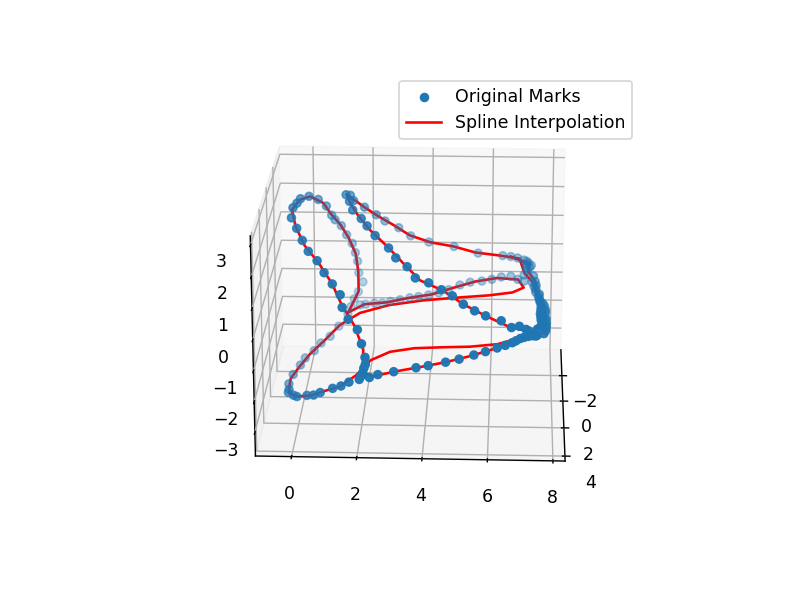

In [5]:
'''
拓扑图算法雏形
'''

import numpy as np
import networkx as nx
import scipy.interpolate as spi
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

def load_mark_file(file_path):
    marks = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 3:
                    mark = [float(parts[0]), float(parts[1]), float(parts[2])]
                    marks.append(mark)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return marks

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def generate_topology(marks):
    G = nx.Graph()
    tree = KDTree(marks)
    for i, mark in enumerate(marks):
        G.add_node(i, pos=mark)
        distances, indices = tree.query(mark, k=3)  # 找到最近的两个邻居
        for j in indices[1:]:  # 跳过自己
            if not G.has_edge(i, j):
                G.add_edge(i, j)
    return G

def spline_interpolation(G):
    pos = nx.get_node_attributes(G, 'pos')
    sorted_nodes = list(nx.dfs_preorder_nodes(G))
    points = np.array([pos[node] for node in sorted_nodes])
    
    tck, u = spi.splprep(points.T, s=0)
    unew = np.linspace(0, 1.0, 100)
    out = spi.splev(unew, tck)
    
    return out

# 使用示例
obj_vertices, obj_faces = load_obj_file('多分类预处理测试数据/1.obj')
centered_vertices = center_vertices(obj_vertices)
marks = load_mark_file('多分类预处理测试数据/1.obj.mark')
G = generate_topology(marks)
spline_points = spline_interpolation(G)

# 绘制OBJ点云和样条插值结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制中心化后的OBJ点云
centered_vertices_array = np.array(centered_vertices)
# ax.scatter(centered_vertices_array[:, 0], centered_vertices_array[:, 1], centered_vertices_array[:, 2], label='OBJ Points')

# 绘制原始标记点
marks_array = np.array(marks)
ax.scatter(marks_array[:, 0], marks_array[:, 1], marks_array[:, 2], label='Original Marks')

# 绘制样条插值曲线
ax.plot(spline_points[0], spline_points[1], spline_points[2], 'r-', label='Spline Interpolation')

ax.legend()
plt.show()


<IPython.core.display.Javascript object>


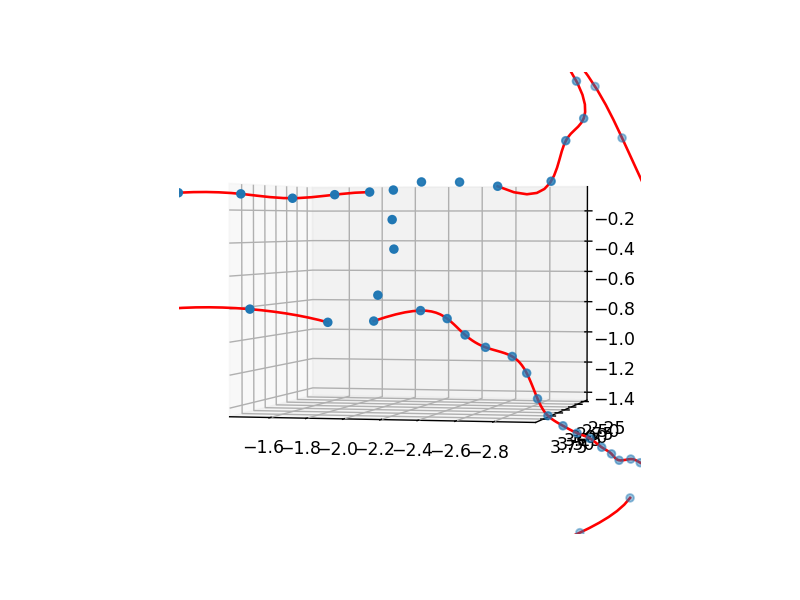

In [7]:
'''
加入度筛选和路径识别
'''

import numpy as np
import networkx as nx
import scipy.interpolate as spi
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def load_mark_file(file_path):
    marks = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 3:
                    mark = [float(parts[0]), float(parts[1]), float(parts[2])]
                    marks.append(mark)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return marks

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def generate_topology(marks):
    G = nx.Graph()
    tree = KDTree(marks)
    for i, mark in enumerate(marks):
        G.add_node(i, pos=mark)
        distances, indices = tree.query(mark, k=3)  # 找到最近的两个邻居
        for j in indices[1:]:  # 跳过自己
            if not G.has_edge(i, j):
                G.add_edge(i, j)
    return G

def find_junction_points(G):
    junction_points = [node for node, degree in G.degree() if degree > 2]
    return junction_points

def spline_interpolation_between_junctions(G, k=3):
    pos = nx.get_node_attributes(G, 'pos')
    junction_points = find_junction_points(G)
    splines = []

    for i, jp1 in enumerate(junction_points):
        for jp2 in junction_points[i+1:]:
            all_paths = list(nx.all_simple_paths(G, source=jp1, target=jp2))
            for path in all_paths:
                if all(G.degree[node] == 2 for node in path[1:-1]) and len(path) > k:
                    points = np.array([pos[node] for node in path])
                    tck, u = spi.splprep(points.T, s=0)
                    unew = np.linspace(0, 1.0, 100)
                    out = spi.splev(unew, tck)
                    splines.append(out)

    return splines

# 使用示例
obj_vertices, obj_faces = load_obj_file('多分类预处理测试数据/1.obj')
centered_vertices = center_vertices(obj_vertices)
marks = load_mark_file('多分类预处理测试数据/1.obj.mark')
G = generate_topology(marks)
splines = spline_interpolation_between_junctions(G)

# 绘制结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制中心化后的OBJ点云
centered_vertices_array = np.array(centered_vertices)
# ax.scatter(centered_vertices_array[:, 0], centered_vertices_array[:, 1], centered_vertices_array[:, 2], label='OBJ Points')

# 绘制原始标记点
marks_array = np.array(marks)
ax.scatter(marks_array[:, 0], marks_array[:, 1], marks_array[:, 2], label='Original Marks')

# 绘制样条插值曲线
for spline in splines:
    ax.plot(spline[0], spline[1], spline[2], 'r-', label='Spline Interpolation')

# ax.legend()
plt.show()


<IPython.core.display.Javascript object>


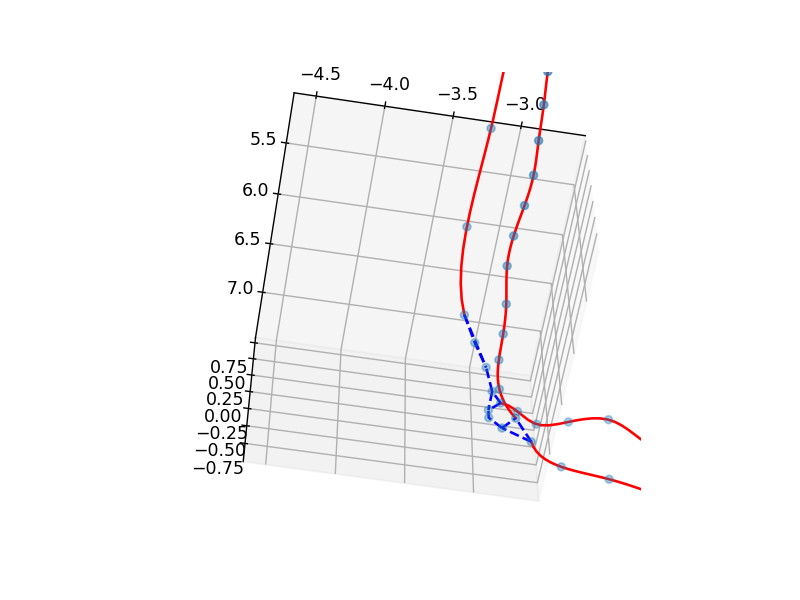

In [9]:
import numpy as np
import networkx as nx
import scipy.interpolate as spi
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def load_mark_file(file_path):
    marks = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 3:
                    mark = [float(parts[0]), float(parts[1]), float(parts[2])]
                    marks.append(mark)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return marks

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def generate_topology(marks):
    G = nx.Graph()
    tree = KDTree(marks)
    for i, mark in enumerate(marks):
        G.add_node(i, pos=mark)
        distances, indices = tree.query(mark, k=3)  # 找到最近的两个邻居
        for j in indices[1:]:  # 跳过自己
            if not G.has_edge(i, j):
                G.add_edge(i, j)
    return G

def find_junction_points(G):
    junction_points = [node for node, degree in G.degree() if degree > 2]
    return junction_points

def spline_interpolation_between_junctions(G, k=3):
    pos = nx.get_node_attributes(G, 'pos')
    junction_points = find_junction_points(G)
    splines = []
    short_paths = []

    for i, jp1 in enumerate(junction_points):
        for jp2 in junction_points[i+1:]:
            all_paths = list(nx.all_simple_paths(G, source=jp1, target=jp2))
            for path in all_paths:
                if all(G.degree[node] == 2 for node in path[1:-1]):
                    points = np.array([pos[node] for node in path])
                    if len(path) > k:
                        tck, u = spi.splprep(points.T, s=0)
                        unew = np.linspace(0, 1.0, 100)
                        out = spi.splev(unew, tck)
                        splines.append(out)
                    else:
                        short_paths.append(points)

    return splines, short_paths

# 使用示例
obj_vertices, obj_faces = load_obj_file('多分类预处理测试数据/1.obj')
centered_vertices = center_vertices(obj_vertices)
marks = load_mark_file('多分类预处理测试数据/1.obj.mark')
G = generate_topology(marks)
splines, short_paths = spline_interpolation_between_junctions(G)

# 绘制结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制中心化后的OBJ点云
centered_vertices_array = np.array(centered_vertices)
# ax.scatter(centered_vertices_array[:, 0], centered_vertices_array[:, 1], centered_vertices_array[:, 2], label='OBJ Points')

# 绘制原始标记点
marks_array = np.array(marks)
ax.scatter(marks_array[:, 0], marks_array[:, 1], marks_array[:, 2], label='Original Marks')

# 绘制样条插值曲线
for spline in splines:
    ax.plot(spline[0], spline[1], spline[2], 'r-', label='Spline Interpolation')

# 绘制长度不足以插值的路径
for path in short_paths:
    ax.plot(path[:, 0], path[:, 1], path[:, 2], 'b--', label='Short Path')

# ax.legend()
plt.show()


<IPython.core.display.Javascript object>


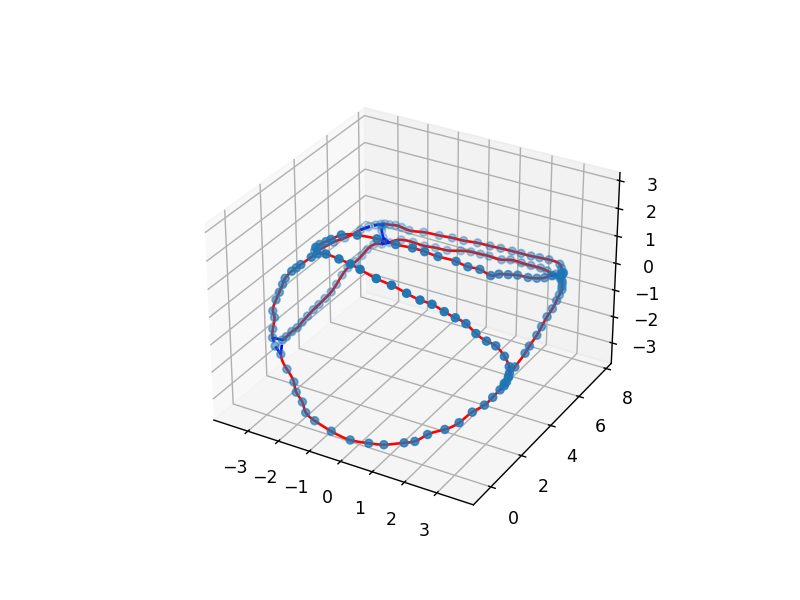

In [12]:
# 绘制结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制中心化后的OBJ点云
centered_vertices_array = np.array(centered_vertices)
# ax.scatter(centered_vertices_array[:, 0], centered_vertices_array[:, 1], centered_vertices_array[:, 2], label='OBJ Points')

# 绘制原始标记点
marks_array = np.array(marks)
ax.scatter(marks_array[:, 0], marks_array[:, 1], marks_array[:, 2], label='Original Marks')

# 绘制样条插值曲线
for spline in splines:
    ax.plot(spline[0], spline[1], spline[2], 'r-', label='Spline Interpolation')

# 绘制长度不足以插值的路径
for path in short_paths:
    ax.plot(path[:, 0], path[:, 1], path[:, 2], 'b--', label='Short Path')

# ax.legend()
plt.show()